# Building a stock database using Polygon and Sharadar
*Python 3.11.4*

The goal is to create a financial database of 1-minute OHLCV data, fundamentals and alternative data from 2004 and beyond, delisted or listed, for common stocks and ADR common stocks. I use Polygon for price data, which is "ticker-centric". All data from Polygon is point-in-time by ticker. This means we have to take care of renamings ourselves. Some vendors already do renamings (e.g. Tiingo). And almost all of the vendors that do renamings have a small bit of survivorship-bias, because when a ticker is re-used they do not have them.

With a previous project I tried to convert tick quote data to quotes and then merge them with bars to get a realistic bid-ask spread. I have decided to not use quote data anymore. It is simply too expensive, cumbersome or simply impossible. I would have to download ALL tick data in order to get quotebars. Instead, I will just trade using 1-minute OHLC. When backtesting, I will assume a spread of 1 tick or a few cents. This is okay, because I simply will not trade HFT or systems with an average profit less than 0.3% for liquid stocks or less than 0.1% for liquid futures/CFDs. High frequency systems also won't work in Europe due to almost not having access to PFOF brokers. I also will avoid illiquid stocks. If I want a more realistic estimate, I will sample the bid-ask spread throughout the day. 

I will organize my data in the following way (only folders and important files shown):

```
├── data_import (current directory)
├── data
│   ├── market
│   │   ├── market_hours.csv
│   │   ├── trading_minutes.csv
│   ├── polygon
│   │   ├── raw
│   │   |   ├── m1
│   │   |   ├── cleaned
│   │   |   ├── adjustments
│   │   |   ├── tickers
│   │   ├── processed
│   │   |   ├── m1
│   │   |   ├── m5
│   │   |   ├── d1
│   │   ├── secret.txt
│   ├── stockanalysis
│   │   ├── raw
│   ├── sharadar
│   │   ├── raw
│   │   ├── processed
│   │   ├── secret.txt
```

The <code>market</code> folder will contain the market hours. All data will be stored in the corresponding directory based on the data vendor. Polygon is for stock/fundamental data. Stockanalysis is for stock renamings and Sharadar is for fundamentals. Raw data is never adjusted. When updating raw data, we should be able to just append it. Processed data is always adjusted which means it is usable by the backtester. The backtester should only use what is in the <code>processed</code> folders. The <code>secret.txt</code> files contain the API keys. All folders have to be created manually. 

Because the rate limit for the free Polygon plan is quite low, you need at least the starter subscription (29 USD/month). They actually have a 20% discount for students.

The most important file is <code>tickers_v{version}.csv</code> which resides in the <code>data</code> folder. This is a csv containing all tickers. This is the while which you have to loop through when filtering/backtesting. It is not an easy task to build the ticker lists. Or even handle to all other problems such as renamings, delistings, early closes, dividends and splits. I have spent quite some time on this. You *cannot* just loop through the most recent ticker list that Polygon provides.

The series of notebooks:
1. An introduction to the problems with the Polygon ticker list. There are many.
2. Get market hours. [U]
3. Solve the ticker problems to create a correct list of tickers.
4. Add ETPs. *(optional)*
5. Download adjustments.
6. Download raw prices.
7. Data cleaning. **Postponed**
8. Processing data.
9. Renamings.
10. Aggregate to higher timeframes.
11. Some extra handy functions.
12. Using the data in practice.

<!-- 2. Get adjustment factors.
3. Download raw 1-minute OHLC data. After converting the Unix timestamp to ET-naive datetimes, the columns are <code>["datetime", "open", "high", "low", "close", "volume"]</code>.
4. Clean suspicious bars with quote/tick data. All cleaned bars are stored in the folder <code>cleaned</code>. **(Postponed because I currently cannot afford the tick data subscription)**
5. Process raw data. When data is downloaded for the first time or updated, the *entire* data set needs be processed (for the updated tickers). This is because if new adjustments come in due to dividend or split data, the entire history needs to be readjusted. Processed data will contain the columns <code>["open", "high", "low", "close", "close_original", "volume", "tradeable", "cleaned", "halted"]</code>. All prices are adjusted, except <code>close_original</code>. The reason we need the original close price is for price filters and fundamentals. Processed data should have no gaps. If data is forward filled, the backtester should not trade these 'stale' prices. Either there have been no trades in the minute or the stock is halted. That is what the <code>tradeable</code> and <code>halted</code> flag is for. The <code>cleaned</code> flag is for if the bar has been cleaned.
6. Process ticker changes.
7. Aggregate processed 1-minute bars to higher timeframes.
8. Get fundamentals from Polygon and Sharadar. **(Postponed)** -->

*Note: a data point at 15:59 with OHLC means that the open was at 15:59:00 and close at 16:00:00. So daily data does not contain the 16:00:00 minute bar. My polygon key is in <code>../../../data/polygon/secret.txt</code>, this file has to be created manually, just like the folders.*

In [2]:
#####
from polygon.rest import RESTClient
from datetime import datetime, date, time, timedelta
from pytz import timezone
import os
import pytz
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import mplfinance as mpf

POLYGON_DATA_PATH = "../data/polygon/"

START_DATE = date(2019, 1, 1)
END_DATE = date(2023, 9, 1)

# There is no guarantee that START_DATE and END_DATE is a trading date. We will handle this later.

with open(POLYGON_DATA_PATH + "secret.txt") as f:
    KEY = next(f).strip()

client = RESTClient(api_key=KEY)

# 1.1 Tickers
We are only interested in common stocks (CS) and ADR commons (ADRC) in the US only that are not OTC. It must also include the delisted stocks. So we need to get 4 different set of tickers: CS+active, CS+inactive, ADRC+active, ADRC+inactive. Setting the <code>asset_class</code> to "stocks" only pulls non-OTC tickers. The <code>list_tickers</code> returns an iterator. Every iteration is 1 request with the specified <code>limit</code>.


In [3]:
print(pd.DataFrame(client.get_ticker_types(asset_class="stocks", locale="us")))

   asset_class     code                            description locale
0       stocks       CS                           Common Stock     us
1       stocks      PFD                        Preferred Stock     us
2       stocks  WARRANT                                Warrant     us
3       stocks    RIGHT                                 Rights     us
4       stocks     BOND                         Corporate Bond     us
5       stocks      ETF                   Exchange Traded Fund     us
6       stocks      ETN                   Exchange Traded Note     us
7       stocks      ETV                Exchange Traded Vehicle     us
8       stocks       SP                     Structured Product     us
9       stocks     ADRC     American Depository Receipt Common     us
10      stocks     ADRP  American Depository Receipt Preferred     us
11      stocks     ADRW   American Depository Receipt Warrants     us
12      stocks     ADRR     American Depository Receipt Rights     us
13      stocks     F

In [4]:
ticker_list_iterator_active = client.list_tickers(type="CS", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_iterator_delisted = client.list_tickers(type="CS", date=END_DATE.isoformat(), active=False, market='stocks', limit=1000)
ticker_list_iterator_active_adr = client.list_tickers(type="ADRC", date=END_DATE.isoformat(), active=True, market='stocks', limit=1000)
ticker_list_iterator_delisted_adr = client.list_tickers(type="ADRC", date=END_DATE.isoformat(), active=False, market='stocks', limit=1000)
tickers_active = pd.DataFrame(ticker_list_iterator_active)
tickers_delisted = pd.DataFrame(ticker_list_iterator_delisted)
tickers_active_adr = pd.DataFrame(ticker_list_iterator_active_adr)
tickers_delisted_adr = pd.DataFrame(ticker_list_iterator_delisted_adr)

In [5]:
tickers_active.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001090872,BBG000C2V3D6,usd,None,None,None,None,2023-09-01T00:00:00Z,us,stocks,Agilent Technologies Inc.,XNYS,BBG001SCTQY4,A,CS,None
1,True,0001675149,BBG00B3T3HD3,usd,None,None,None,None,2023-10-17T00:00:00Z,us,stocks,Alcoa Corporation,XNYS,BBG00B3T3HF1,AA,CS,None
2,True,0001829432,None,usd,None,None,None,None,2023-10-17T00:00:00Z,us,stocks,Ares Acquisition Corporation,XNYS,None,AAC,CS,None


In [7]:
tickers_delisted.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,False,0000004281,None,usd,None,None,None,2016-10-07T00:00:00Z,2016-10-07T00:00:00Z,us,stocks,ALCOA INC,XNYS,None,AA,CS,None
1,False,0000004281,None,usd,None,None,None,2016-11-01T00:00:00Z,2016-11-01T00:00:00Z,us,stocks,"Alcoa, Inc.",XNYS,None,AA,CS,None
2,False,0001011006,BBG000KB2D74,usd,None,None,None,2019-10-07T00:00:00Z,2019-10-07T00:00:00Z,us,stocks,Altaba Inc. Common Stock,XNAS,BBG001S8V781,AABA,CS,None


In [8]:
tickers_active_adr.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001420529,BBG000V2S3P6,usd,None,None,None,None,2023-10-17T00:00:00Z,us,stocks,ATA Creativity Global American Depositary Shares,XNAS,BBG001T125S9,AACG,ADRC,None
1,True,0001492074,BBG00XRJJLG2,usd,None,None,None,None,2023-09-07T00:00:00Z,us,stocks,Abcam plc American Depositary Shares,XNAS,BBG00XRJJM98,ABCM,ADRC,None
2,True,0001565025,BBG000BN5VZ4,usd,None,None,None,None,2023-10-10T00:00:00Z,us,stocks,AMBEV S.A.,XNYS,BBG005KLVT74,ABEV,ADRC,None


In [9]:
tickers_delisted_adr.head(3)

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,False,0001611787,BBG00K6FMBQ8,usd,None,None,None,2018-02-12T00:00:00Z,2018-02-12T00:00:00Z,us,stocks,Advanced Accelerator Applications S.A. America...,XNAS,BBG007K5CVB6,AAAP,ADRC,None
1,False,0001091587,BBG000DK5Q25,usd,None,None,None,2023-05-23T00:00:00Z,2023-05-23T00:00:00Z,us,stocks,ABB Ltd.,XNYS,BBG001SDDMX9,ABB,ADRC,None
2,False,0001617582,None,usd,None,None,None,2018-06-13T00:00:00Z,2018-06-13T00:00:00Z,us,stocks,Ablynx NV American Depositary Shares,XNAS,None,ABLX,ADRC,None


In [10]:
tickers = pd.concat([tickers_active, tickers_delisted, tickers_active_adr, tickers_delisted_adr]).reset_index()

Some basic checks to check for weird things:

In [11]:
# Check na values
tickers.isna().sum()

index                       0
active                      0
cik                       649
composite_figi           6183
currency_name               0
currency_symbol         13904
base_currency_symbol    13904
base_currency_name      13904
delisted_utc             5884
last_updated_utc            0
locale                      0
market                      0
name                        0
primary_exchange            0
share_class_figi         6183
ticker                      0
type                        0
source_feed             13904
dtype: int64

In [12]:
# Check unique values 
print(tickers['currency_name'].unique()) # Should be USD only
print(tickers['locale'].unique()) # Should be US only

['usd']
['us']


In [13]:
# Clean up and rearrange columns
tickers_active = tickers_active[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_delisted = tickers_delisted[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_active_adr = tickers_active_adr[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers_delisted_adr = tickers_delisted_adr[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]
tickers = tickers[['ticker', 'name', 'active', 'delisted_utc', 'last_updated_utc', 'cik', 'composite_figi', 'type']]

# 1.2 Problem: duplicates

Check if all tickers are unique:

In [14]:
ticker_frequency = tickers.pivot_table(columns=['ticker'], aggfunc='size')
ticker_frequency[ticker_frequency > 1]

ticker
AA      3
AAC     4
AAN     4
AAU     2
AAV     2
       ..
ZME     2
ZOM     2
ZSAN    3
ZTR     2
ZYME    2
Length: 1996, dtype: int64

Apparently they are not unique. There are more than 1800 duplications. Maybe it is because tickers get recycled after delisting?

In [15]:
ticker_frequency_active = tickers_active.pivot_table(columns=['ticker'], aggfunc='size')
ticker_frequency_active[ticker_frequency_active > 1]

Series([], dtype: int64)

There are indeed no duplicates in the active stocks. The tickers are recycled:

In [16]:
tickers[tickers['ticker'] == "AAN"]


,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
10,AAN,"The Aaron's Company, Inc.",True,None,2023-10-17T00:00:00Z,0001821393,BBG00WCNDCZ6,CS
5470,AAN,AARON'S INC CL B,False,2010-12-14T00:00:00Z,2010-12-14T00:00:00Z,0000706688,None,CS
5471,AAN,"Aaron's, Inc.",False,2020-10-19T00:00:00Z,2020-10-19T00:00:00Z,0000706688,BBG00JZD1964,CS
5472,AAN,"Aaron''s Holdings Company, Inc.",False,2020-12-01T00:00:00Z,2020-12-01T00:00:00Z,0001821393,BBG00XYJSN34,CS


However this is not even a real recycling. It's the *same* company. Yet it has different entries because it changed its name. We will have to merge them later.

We need to keep this in mind if we download historical data. Because we cannot just loop through all tickers and then store them in a csv. Because then the first ones will be overwritten.

The cik is also not unique.

In [17]:
ticker_frequency = tickers.pivot_table(columns=['cik'], aggfunc='size')
ticker_frequency[ticker_frequency > 1]

cik
0000002186    3
0000002491    2
0000003197    2
0000003327    3
0000003453    2
             ..
0001951222    2
0001955520    2
0001957146    2
0001965040    2
0001968915    2
Length: 2429, dtype: int64

In [18]:
tickers[tickers['cik'] == "0000002186"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
702,BKTI,BK Technologies Corporation,True,None,2023-10-17T00:00:00Z,0000002186,BBG00NKSM4N7,CS
6350,BKTI,BK Technologies Corporation,False,2023-04-24T00:00:00Z,2023-04-24T00:00:00Z,0000002186,BBG00NKSM4N7,CS
11447,RWC,RELM Wireless Corporation,False,2018-06-05T00:00:00Z,2018-06-05T00:00:00Z,0000002186,None,CS


If a ticker is *actually* delisted we can handle this in at least 2 different ways:
* The [Norgate](https://norgatedata.com/data-package-faq.php) way: the data of active tickers is just saved under the ticker name. For delisted tickers the delisting date is appended to the ticker. E.g. FB-2022-06.csv
* My preferred way: Always assign an unique ID to the stocks. I chose to always append the *listing date* to the stock. This is because the listing date never changes. I am aware that other identifiers such as CUSIP exists. However Polygon does not even provide this and everyone uses another identifier. I like to be 'ticker-centric' because that coincides with charting platforms. I want to keep a history of all ticker changes to always be able to map it to other identifiers.

We need to keep in mind that it is possible for a ticker to go to OTC and then back (see HTZ on TradingView). We will treat these cases as two different stocks, such that we do not trade OTC. We won't even use the OTC data.

In [19]:
tickers.sort_values(by=['ticker'], inplace=True)
# We are not interested in stocks that were delisted before the start date
tickers['delisted_utc'] = pd.to_datetime(tickers['delisted_utc'])
tickers['last_updated_utc'] = pd.to_datetime(tickers['last_updated_utc'])
tickers = tickers[(tickers['delisted_utc'].dt.date > START_DATE) | tickers['delisted_utc'].isnull()]
tickers.reset_index(inplace=True, drop=True)
tickers

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type
0,A,Agilent Technologies Inc.,True,NaT,2023-09-01 00:00:00+00:00,0001090872,BBG000C2V3D6,CS
1,AA,Alcoa Corporation,True,NaT,2023-10-17 00:00:00+00:00,0001675149,BBG00B3T3HD3,CS
2,AABA,Altaba Inc. Common Stock,False,2019-10-07 00:00:00+00:00,2019-10-07 00:00:00+00:00,0001011006,BBG000KB2D74,CS
3,AAC,"AAC Holdings, Inc.",False,2019-10-28 00:00:00+00:00,2019-10-28 00:00:00+00:00,0001606180,BBG00K1Y3PT9,CS
4,AAC,Ares Acquisition Corporation,True,NaT,2023-10-17 00:00:00+00:00,0001829432,None,CS
...,...,...,...,...,...,...,...,...
9535,ZY,Zymergen Inc. Common Stock,False,2022-10-20 00:00:00+00:00,2022-10-20 00:00:00+00:00,0001645842,BBG0077HPN74,CS
9536,ZYME,Zymeworks Inc.,False,2022-10-13 00:00:00+00:00,2022-10-13 00:00:00+00:00,0001403752,BBG00GD15LJ5,CS
9537,ZYME,Zymeworks Inc.,True,NaT,2023-10-17 00:00:00+00:00,0001937653,BBG019XSYC89,CS
9538,ZYNE,"Zynerba Pharmaceuticals, Inc",True,NaT,2023-10-11 00:00:00+00:00,0001621443,BBG007BBS8B7,CS


# 1.3 Problem: no start dates
We now have the end dates. But to download the data we also need the start date. Let's try to get the start date of META. To get them we could use the <code>Ticker Details</code> endpoint. But this gets the *list date*. This is not necessarily the same as the start date of a ticker. E.g. FB changed their ticker to META, but what does ticker details give? We want 2022.

If a ticker changes, we treat them as 2 different stocks. In the end, we should thus get a META.csv and a FB.csv. We can merge them later *after* downloading all data. The purpose of the ticker list is to know what data to download since downloading data uses the ticker.

In [20]:
meta_details = client.get_ticker_details(ticker = "META")
meta_details.list_date

'2012-05-18'

In [21]:
result = client.get_ticker_events(ticker="META")
result

TickerChangeResults(name='Meta Platforms, Inc. Class A Common Stock', composite_figi='BBG000MM2P62', cik='0001326801', events=[{'ticker_change': {'ticker': 'META'}, 'type': 'ticker_change', 'date': '2022-06-09'}, {'ticker_change': {'ticker': 'FB'}, 'type': 'ticker_change', 'date': '2012-05-18'}])

The start date of META is 2022-06-09. But the list date is the one from FB from 2012. We cannot use <code>get_ticker_events</code> because it does not include delisted companies. 

What happens if we download data from a ticker that had ticker changes, without the correct start/end date?

In [22]:
meta_iterator = client.get_aggs(ticker = "META", multiplier = 1, timespan = "day", from_ = "2010-01-01", to = "2023-08-18", limit=50000)
meta_d1 = pd.DataFrame(meta_iterator)
meta_d1["timestamp"] = pd.to_datetime(meta_d1["timestamp"], unit="ms").dt.date
meta_d1.rename(columns={"timestamp": "date"}, inplace=True)
meta_d1


,open,high,low,close,volume,vwap,date,transactions,otc
0,15.0800,15.19,15.042,15.12,334935.0,15.1107,2021-06-30,2101,None
1,15.1300,15.13,14.840,14.89,241629.0,15.0126,2021-07-01,2092,None
2,15.0200,15.10,14.930,15.00,388152.0,15.0224,2021-07-02,4733,None
3,15.0800,15.09,14.870,15.01,685094.0,15.1119,2021-07-06,11269,None
4,15.0601,15.15,14.840,14.89,362538.0,14.9830,2021-07-07,5538,None
...,...,...,...,...,...,...,...,...,...
443,300.9800,306.21,298.250,306.19,15641921.0,303.0529,2023-08-14,206053,None
444,306.1400,307.23,300.030,301.95,11623613.0,302.9223,2023-08-15,171652,None
445,300.1950,301.08,294.280,294.29,18547741.0,297.3013,2023-08-16,261408,None
446,293.0500,296.05,284.950,285.09,23950089.0,289.9367,2023-08-17,311835,None


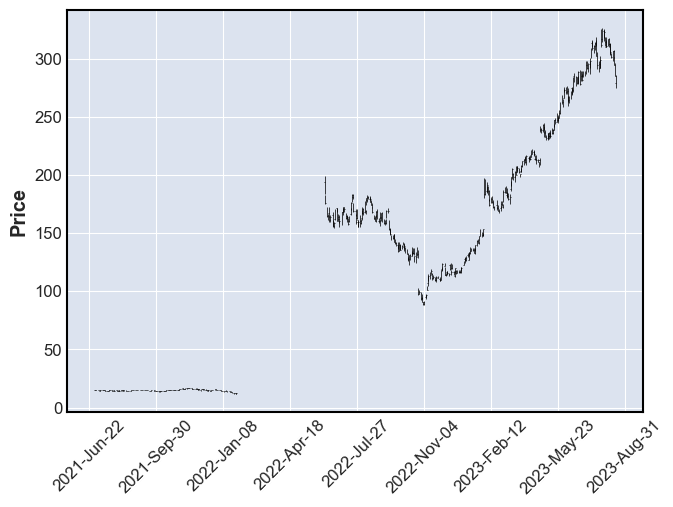

In [23]:
meta_d1.set_index("date", inplace=True)
meta_d1.index = pd.to_datetime(meta_d1.index)
mpf.plot(meta_d1, type='ohlc', show_nontrading=True)

So if a ticker was used by another company/ETF and you download data from the ticker, you get them *both*. The first ticker that used META was actually a metaverse ETF. However what we need is the data from FB up to the renaming, and then the META data.

In [25]:
fb_iterator = client.get_aggs(ticker = "FB", multiplier = 1, timespan = "day", from_ = "2010-01-01", to = "2023-08-18", limit=50000)
fb_d1 = pd.DataFrame(fb_iterator)
fb_d1["timestamp"] = pd.to_datetime(fb_d1["timestamp"], unit="ms").dt.date
fb_d1.rename(columns={"timestamp": "date"}, inplace=True)
fb_d1

,open,high,low,close,volume,vwap,date,transactions,otc
0,175.90,179.7901,175.7000,177.64,24216532.0,178.2862,2018-08-30,172773,None
1,177.15,177.6200,174.9815,175.73,18065159.0,175.7343,2018-08-31,135914,None
2,173.50,173.8900,168.8000,171.16,29808971.0,171.1312,2018-09-04,234508,None
3,169.49,171.1250,166.6700,167.18,31203944.0,168.3393,2018-09-05,237150,None
4,166.98,166.9800,160.0000,162.53,41509084.0,163.0707,2018-09-06,322847,None
...,...,...,...,...,...,...,...,...,...
945,188.45,200.9350,187.7300,198.86,31951582.0,195.8094,2022-06-02,336899,None
946,195.98,196.6100,189.7800,190.78,19464993.0,192.0885,2022-06-03,239486,None
947,193.99,196.9200,188.4000,194.25,30574242.0,193.2857,2022-06-06,307707,None
948,191.93,196.5300,191.4900,195.65,18628687.0,194.4583,2022-06-07,204288,None


**The FB ticker also does not show up in the ticker list!** Not even with a <code>active</code> set to False.

In [23]:
tickers[tickers['ticker'] == "FB"]

,ticker,name,active,delisted_utc,last_updated_utc,cik,composite_figi,type


It *does* show up in the Polygon ticker list from before the renaming.

In [25]:
# Before the renaming on 6-9
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-08", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001326801,BBG000MM2P62,usd,None,None,None,None,2022-06-08T00:00:00Z,us,stocks,"Meta Platforms, Inc. Class A Common Stock",XNAS,BBG001SQCQC5,FB,CS,None


In [26]:
# After the renaming on 6-9: No FB but we do have META
ticker_list_iterator_fb = client.list_tickers(ticker="FB", type="CS", date="2022-06-09", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

""


In [30]:
ticker_list_iterator_fb = client.list_tickers(ticker="META", type="CS", date="2022-06-09", active=True, market='stocks', limit=1000)
df = pd.DataFrame(ticker_list_iterator_fb)
df

,active,cik,composite_figi,currency_name,currency_symbol,base_currency_symbol,base_currency_name,delisted_utc,last_updated_utc,locale,market,name,primary_exchange,share_class_figi,ticker,type,source_feed
0,True,0001326801,BBG000MM2P62,usd,None,None,None,None,2022-06-09T00:00:00Z,us,stocks,"Meta Platforms, Inc. Class A Common Stock",XNAS,BBG001SQCQC5,META,CS,None


Apparently when a stock renames, the <code>Tickers</code> gets updated by **removing** the old ticker and adding the new one. It also does not treat it as a delisting (there is no <code>delisted_utc</code>). 

This is quite problematic. The only way to get the end date of FB is to loop through all trading days in <code>Tickers</code> and see when the ticker dissappears. The only way to get the start date of the META or FB is also to loop, but then to track when the ticker appears. We cannot use the <code>Ticker Events</code> because it does not include delisted stocks. So information actually gets lost in the <code>Tickers</code> endpoint. Although you would just expect the <code>active</code> flag to be set to False.

Who thought that just getting all available tickers would be such a headache? We haven't even begun downloading data.

To summarize:
- Getting data is truly point-in-time, there is no META data for 2022-04-01 (after META ETF, before FB rename), but there is FB data before the META renaming. If the same ticker had different stocks, they are merged when downloading data which we do not want. So we **must** specify a precise start and end date for each stock, else we might get merging from different stocks. And it is not possible to get the start and end dates from <code>list_tickers</code>. Because it simply does not contain the start date. And also not the renamed tickers.
- The <code>Tickers</code> endpoint does **not** include FB in the 'inactive' tickers if we use the current date. So the <code>Tickers</code> is also 'point in time' and **deletes** some data, such as FB.

So we will loop and create an own version of a list of all tickers with start and end dates. This will include FB, which would not be the case if we only used the current date in <code>Tickers</code>. It would also include the old META ETF if it was a stock. This would be impossible to get without looping.

We will take a short stop to retrieve the market hours. This is important if we want to loop through the trading days to retrieve the Polygon ticker list for each day.

# 1.4 To be moved to other notebooks

## 1.7 Ticker changes
We need a list of ticker renamings to merge data. E.g. FB and META price data has to be merged. Also when we get fundamentals, for some APIs we can only query by the most recent ticker. For example Sharadar and Tiingo. In fact, most data vendors only uses the most recent ticker, so you will not find FB. (This means that if a ticker is re-used, it is gone. Sharadar actually does have some survivorship bias, although small). In rare cases we do need point-in-time tickers, for example the historical borrowing rates for IBKR. 

We can loop through all tickers and query <code>Ticker Events</code> but this only works with non-delisted companies. And although you can infer it based on the ticker list by looking at whether the cik or figi has changed, that is very messy. Because a company can stay the same even if the ticker and cik/figi change. I actually did it, and it did found that it did not match the Polygon <code>Ticker Events</code>. Then I stumbled on [stockanalysis.com](https://stockanalysis.com/actions/changes/) where you can find all ticker changes for only 10 bucks a month. The first month is even free. 

After downloading and manipulating these, we will save all renaming to <code>raw/renamings.csv</code> which will contain the columns <code>['from', 'to', 'now', 'date']</code>. In the above example, 'from' will be AAA, 'to' will be BBB, and 'date' will be *the next trading day* after 2022-01-01. 

In [33]:
###
# Aggregate the csv's
all_ticker_changes = []
for file in os.listdir(DATA_PATH + "../stockanalysis/raw/ticker_changes/"):
    ticker_changes_year = pd.read_csv(DATA_PATH + "../stockanalysis/raw/ticker_changes/" + file, parse_dates=True, index_col=0, usecols=["Date", "Old", "New"])
    all_ticker_changes.append(ticker_changes_year)

ticker_changes = pd.concat(all_ticker_changes)
ticker_changes = pd.concat(all_ticker_changes)
ticker_changes.rename(columns={"Old": "from", 
                               "New": "to"}, inplace=True)
ticker_changes.index.names = ['date']
ticker_changes.sort_index(inplace=True)
ticker_changes.to_csv(DATA_PATH + "../stockanalysis/ticker_changes.csv")

In [34]:
print(len(ticker_changes))
ticker_changes[ticker_changes['from'] == "FB"]

4347


,from,to
date,,
2022-06-09,FB,META


There are a whopping 4347 ticker changes from 2003 to now that we have to take care of. But at least this was very easy to get.

## 1.9 Updates
The steps for updating:
1. Update <code>END_DATE</code> and run the cells with ##### to import the functions
2. <code>market_hours.csv</code>: Run the cell with ### at section 1.2. Make sure the hard-coded <code>early_closes</code> variable is complete.
3. All raw ticker lists in the map <code>tickers/</code>: Run the 2 cells with ### in section 1.3.
4. <code>tickers_v1.csv</code>: Run the cell with ### in section 1.4.
5. <code>tickers_v2.csv</code>: Run the cells with ### in section 1.5 and 1.6.
6. <code>ticker_changes.csv</code>: Run the cell with ### in section 1.7 after updating the .csv files with the ticker changes in <code>stockanalysis/raw/ticker_changes</code>.
7. <code>tickers_v3.csv</code>: Run the cells with ### in section 1.8.

The code is not optimized to update daily, neither is it necessary or even feasible because processing take very long. I only intend to update only once every month to compare real results to backtested results. But until I have a working strategy and money I will probably not update at all. 